In [1]:
import os
import pickle
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import re 

import xgboost as xgb
from sklearn import ensemble
from sklearn import dummy
from sklearn import linear_model
from sklearn import svm
from sklearn import neural_network
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import loguniform
import scipy
import argparse
from scipy.stats import randint

from misc import save_model, load_model, regression_results, grid_search_cv, supervised_learning_steps, regression_results, calculate_regression_metrics

In [2]:
#Get the setting with different X_trains and X_tests
train_options = ["../Data/Training_Set_with_Drug_Embedding_Cell_Info.pkl",
                 "../Data/Training_Set_with_Drug_MFP_Cell_Info.pkl",
                 ".."]
test_options = ["../Data/Test_Set_with_Drug_Embedding_Cell_Info.pkl",
                "../Data/Test_Set_with_Drug_MFP_Cell_Info.pkl",
                ".."]
data_type_options = ["LS_Feat","MFP_Feat"]

Loaded training file
Shape of training set after removing non-numeric cols
(34387, 1437)
(19184, 1437)
Shape of training set after removing cols with NaNs
(34387, 1424)
(19184, 1424)


(array([1.005e+04, 9.131e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([1.3700000e-03, 5.0012330e+00, 1.0001096e+01, 1.5000959e+01,
        2.0000822e+01, 2.5000685e+01, 3.0000548e+01, 3.5000411e+01,
        4.0000274e+01, 4.5000137e+01, 5.0000000e+01]),
 <BarContainer object of 10 artists>)

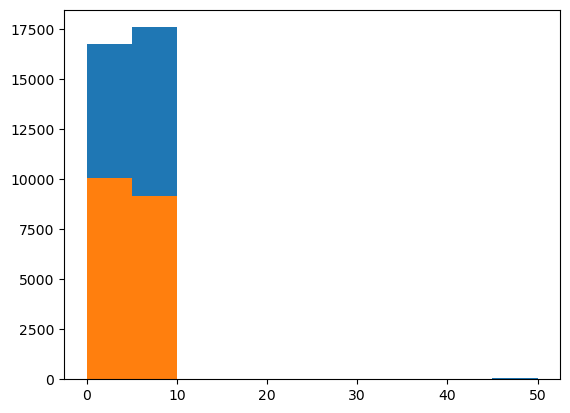

In [3]:
#Choose the options
input_option = 0                                                  #Choose 0 for LS for Drug and LS for Cell Line , 1 for MFP for Drug and LS for Cell Line 
classification_task = False
data_type = data_type_options[input_option]

#Get the data for your choice: LS or MFP
print("Loaded training file")
big_train_df = pd.read_pickle(train_options[input_option],compression="zip")
big_test_df = pd.read_pickle(test_options[input_option],compression="zip")
total_length = len(big_train_df.columns)
if (input_option==0):
    #Consider only those columns which have numeric values
    metadata_X_train,X_train, Y_train = big_train_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]], big_train_df.iloc[:,[1,4]+[*range(6,262,1)]+[*range(288,total_length,1)]], big_train_df["ic50"].to_numpy().flatten()
    metadata_X_test,X_test, Y_test = big_test_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]], big_test_df.iloc[:,[1,4]+[*range(6,262,1)]+[*range(288,total_length,1)]], big_test_df["ic50"].to_numpy().flatten()
elif (input_option==1):
    metadata_X_train,X_train, Y_train = big_train_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]], big_train_df.iloc[:,[1,4]+[*range(6,1030,1)]+[*range(1056,total_length,1)]], big_train_df["ic50"].to_numpy().flatten()
    metadata_X_test,X_test, Y_test = big_test_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]], big_test_df.iloc[:,[1,4]+[*range(6,1030,1)]+[*range(1056,total_length,1)]], big_test_df["ic50"].to_numpy().flatten()

#Keep only numeric training and test set and those which have no Nans
X_train_numerics_only = X_train.select_dtypes(include=np.number)
X_test_numerics_only = X_test[X_train_numerics_only.columns]
print("Shape of training set after removing non-numeric cols")
print(X_train_numerics_only.shape)
print(X_test_numerics_only.shape)


nan_cols = [i for i in X_train_numerics_only.columns if X_train_numerics_only[i].isnull().any()]
rev_X_train = X_train_numerics_only.drop(nan_cols,axis=1)
rev_X_test = X_test_numerics_only.drop(nan_cols,axis=1)
print("Shape of training set after removing cols with NaNs")
print(rev_X_train.shape)
print(rev_X_test.shape)
plt.hist(Y_train)
plt.hist(Y_test)

In [ ]:
model = ensemble.RandomForestRegressor(n_estimators=100, criterion='squared_error',
                                                max_depth=None, min_samples_split=2,
                                                min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                                max_features='auto', max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                bootstrap=True, oob_score=False,
                                                n_jobs=64, random_state=328, verbose=1,
                                                warm_start=False, ccp_alpha=0.0, max_samples=None)


# Grid parameters
param_rf={'max_depth':list(np.arange(1, 10, step=2)) + [None],
          'n_estimators':[100,250],
          'max_features':["sqrt",0.1,0.2,0.3],
          'criterion':['squared_error','absolute_error'],
          'min_samples_leaf':np.arange(4,20,step=4)
         }

#It will select 100 random combinations for the CV and do 5-fold CV for each combination
n_iter = 50
rf_gs=supervised_learning_steps("rf","r2",data_type,classification_task,model,param_rf,rev_X_train,Y_train,n_iter=n_iter,n_splits=5)
        
#Build the model and get 5-fold CV results    
print(rf_gs.cv_results_)

Load model to file: ../Models/rf_models/rf_LS_Feat_regressor_gs.pk
(2.727, 3.41, 0.43, 0.656, 0.643)
Finished writing predictions


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 200 out of 200 | elapsed:    0.1s finished


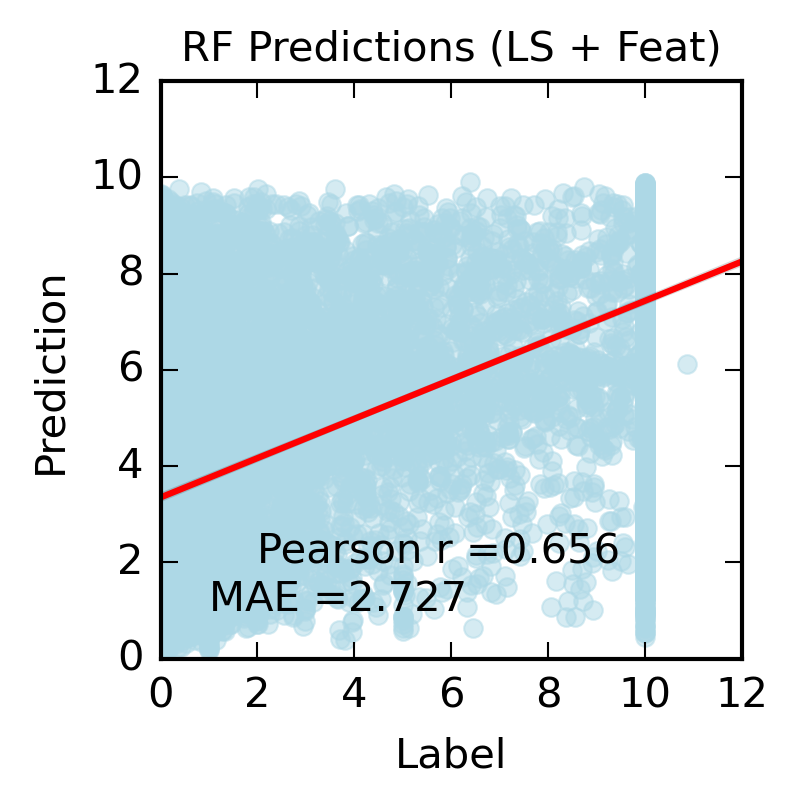

In [4]:
#Test the linear regression model on separate test set  
rf_gs = load_model("rf_models/rf_"+data_type+"_regressor_gs.pk")
np.max(rf_gs.cv_results_["mean_test_score"])
rf_best = rf_gs.best_estimator_
y_pred_rf=rf_best.predict(rev_X_test)
test_metrics = calculate_regression_metrics(Y_test,y_pred_rf)
print(test_metrics)

#Write the prediction of LR model
metadata_X_test['predictions']=y_pred_rf
metadata_X_test['labels']=Y_test
metadata_X_test.to_csv("../Results/RF_"+data_type+"_supervised_test_predictions.csv",index=False)
print("Finished writing predictions")

fig = plt.figure()
plt.style.use('classic')
fig.set_size_inches(2.5,2.5)
fig.set_dpi(300)
fig.set_facecolor("white")

ax = sn.regplot(x="labels", y="predictions", data=metadata_X_test, scatter_kws={"color": "lightblue",'alpha':0.5}, 
                line_kws={"color": "red"})
ax.axes.set_title("RF Predictions (LS + Feat)",fontsize=10)
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.set_xlabel("Label",fontsize=10)
ax.set_ylabel("Prediction",fontsize=10)
ax.tick_params(labelsize=10, color="black")
plt.text(2,2, 'Pearson r =' +str(test_metrics[3]), fontsize = 10)
plt.text(1,1, 'MAE ='+str(test_metrics[0]),fontsize=10)
outfilename = "../Results/RF_"+data_type+"_supervised_test_prediction.pdf"
plt.savefig(outfilename, bbox_inches="tight")

Load model to file: ../Models/rf_models/rf_LS_Feat_regressor_best_estimator.pk


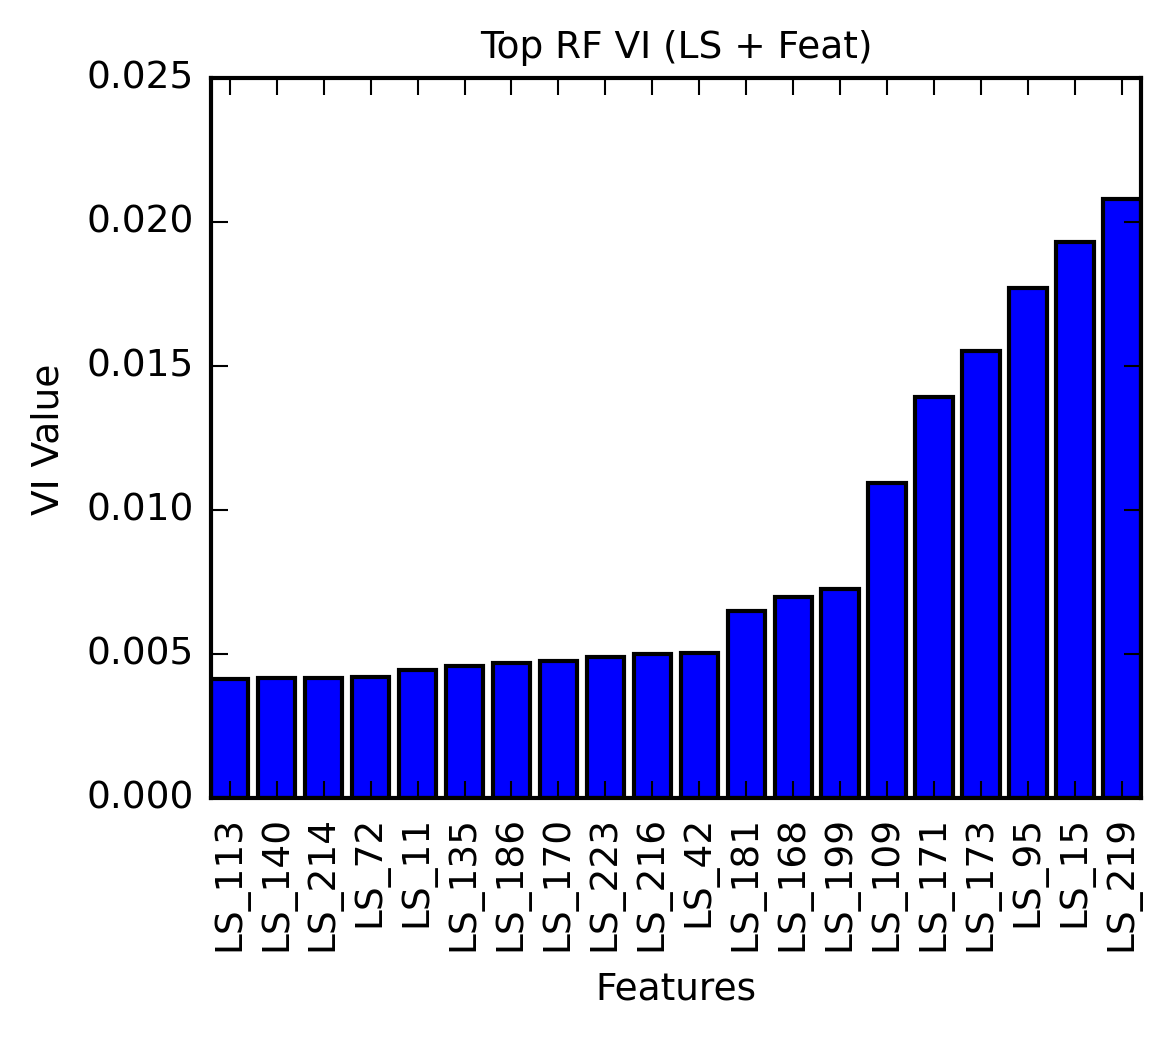

In [5]:
#Get the most important variables and their feature importance scores
rf_best = load_model("rf_models/rf_"+data_type+"_regressor_best_estimator.pk")
val, index = np.sort(rf_best.feature_importances_), np.argsort(rf_best.feature_importances_)
fig = plt.figure()
plt.style.use('classic')
fig.set_size_inches(4,3)
fig.set_dpi(300)
fig.set_facecolor("white")

ax = fig.add_subplot(111)
plt.bar(rev_X_train.columns[index[-20:]],val[-20:])
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

ax.axes.set_title("Top RF VI (LS + Feat)",fontsize=9)
ax.set_xlabel("Features",fontsize=9)
ax.set_ylabel("VI Value",fontsize=9)
ax.tick_params(labelsize=9)
outputfile = "../Results/RF_"+data_type+"_Coefficients.pdf"
plt.savefig(outputfile, bbox_inches="tight")